#### Dataloader 


In [ ]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import numpy as np
from cityscapesscripts.helpers.labels import id2label

class CityscapesDataset(Dataset):
    def __init__(self, image_folder, label_folder,augmentation=None):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.augmentation = augmentation

        # Sort to keep image-label pairing aligned
        self.image_paths = sorted([os.path.join(image_folder, x) for x in os.listdir(image_folder) if x.endswith('.png')])
        self.label_paths = sorted([os.path.join(label_folder, x) for x in os.listdir(label_folder) if x.endswith('gtFine_labelIds.png')])

        # Optional check
        assert len(self.image_paths) == len(self.label_paths), "Mismatch between images and labels"

    def __len__(self):
        return len(self.image_paths) 

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        image=Image.open(image_path).convert('RGB')
        label=Image.open(label_path)
        label=np.array(label)
        label=self.remap_to_train_id(label)


        if self.augmentation:
            augmented = self.augmentation(image=np.array(image), mask=label)
            image = augmented['image']
            label = augmented['mask']
        
        return image, label

    ## this is a funtion to remap the label id to train id because in cutyscaors dataset there are 34 classses, someof which are not useful 
    ## so by converting them into 19 using Github original repo code of cityscapes dataset
    # cityscapesscripts library
    
    def remap_to_train_id(self, label_np):
        label_train = np.full_like(label_np, 255) 
        
        for id, label in id2label.items():
            if label.trainId != -1:  
                label_train[label_np == id] = label.trainId
        
        label_train[label_train == -1] = 255  

        return label_train







/home/lms-02/miniconda3/envs/mss-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_augmentation = A.Compose([
    A.RandomCrop(width=512, height=512),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                max_pixel_value=255.0),
    ToTensorV2()

])

val_augmentation= A.Compose([

    A.Resize(height=512, width=512),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                max_pixel_value=255.0),
    ToTensorV2()
])

In [ ]:
# train_input_dir="/data/Cityscapes/Input/leftImg8bit/train_final"
# train_label_dir="/data/Cityscapes/Output/train_final"
# val_input_dir="/data/Cityscapes/Input/leftImg8bit/val_final"
# val_label_dir="/data/Cityscapes/Output/val_final"
# test_input_dir="/data/Cityscapes/Input/leftImg8bit/test_final"
# test_label_dir="/data/Cityscapes/Output/test_final"

train_input_dir="D:/Citscapes dataset/Input/leftImg8bit/train_final"
train_label_dir="D:/Citscapes dataset/Output/train_final"
val_input_dir="D:/Citscapes dataset/Input/leftImg8bit/val_final"
val_label_dir="D:/Citscapes dataset/Output/val_final"
test_input_dir="D:/Citscapes dataset/Input/leftImg8bit/test_final"
test_label_dir="D:/Citscapes dataset/Output/test_final"



In [4]:
train_dataset = CityscapesDataset(
    image_folder=train_input_dir,
    label_folder=train_label_dir,
    augmentation=train_augmentation
)
val_dataset = CityscapesDataset(
    image_folder=val_input_dir,
    label_folder=val_label_dir,
    augmentation=val_augmentation
)
test_dataset = CityscapesDataset(
    image_folder=test_input_dir,
    label_folder=test_label_dir,
    augmentation=val_augmentation
)

In [5]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)
test_loader = DataLoader(   
    
        test_dataset,
        batch_size=4,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )


Visualizing Validation Dataset Samples:
Sample 0:
  Image Shape: torch.Size([3, 512, 512])
  Label Shape: torch.Size([512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


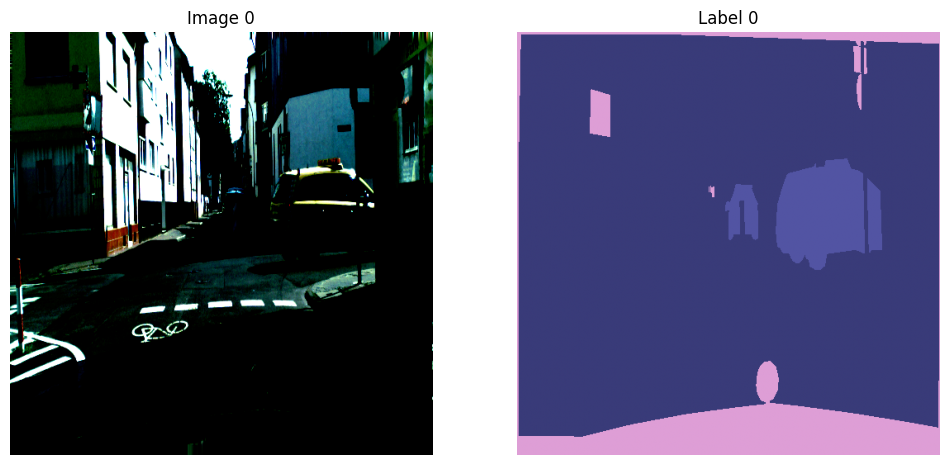

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


Sample 1:
  Image Shape: torch.Size([3, 512, 512])
  Label Shape: torch.Size([512, 512])


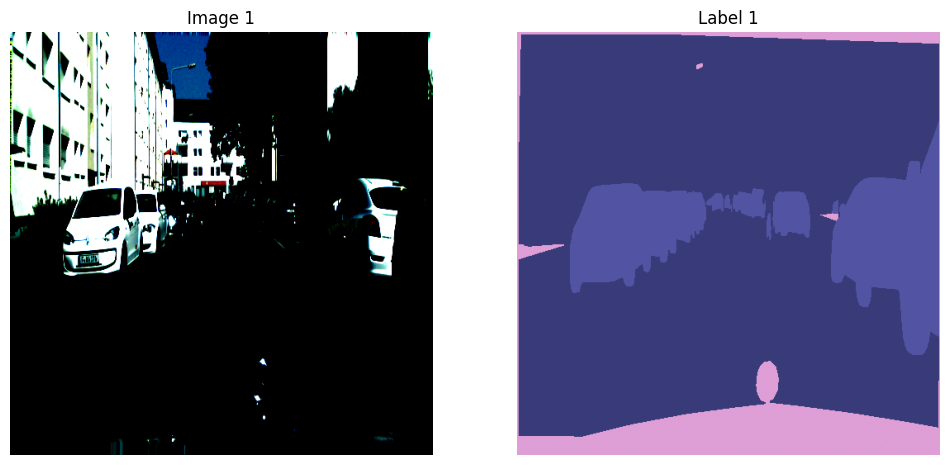

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


Sample 2:
  Image Shape: torch.Size([3, 512, 512])
  Label Shape: torch.Size([512, 512])


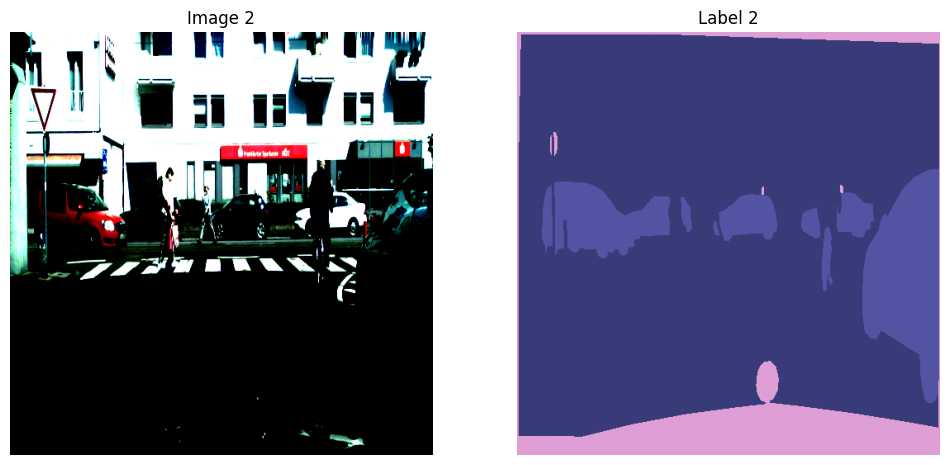

In [6]:
import matplotlib.pyplot as plt

# Function to visualize image and corresponding label
def visualize_sample(image, label, idx):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Image
    ax[0].imshow(image)
    ax[0].set_title(f"Image {idx}")
    ax[0].axis('off')
    
    # Label
    ax[1].imshow(label, cmap='tab20b')  # Use 'tab20b' colormap for labels
    ax[1].set_title(f"Label {idx}")
    ax[1].axis('off')
    
    plt.show()

# Verify shapes by iterating through the datasets
def verify_dataset(dataset, num_samples=5):
    for i in range(num_samples):
        image, label = dataset[i]  # Fetch sample
        
        print(f"Sample {i}:")
        print(f"  Image Shape: {image.shape}")
        print(f"  Label Shape: {label.shape}")
        
        visualize_sample(image.permute(1, 2, 0).numpy(), label.numpy(), i)


# Visualize and print shapes for validation dataset
print("\nVisualizing Validation Dataset Samples:")
verify_dataset(val_dataset, num_samples=3)



In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class ASPPModule(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ASPPModule, self).__init__()


        self.atrousBlock1 = nn.Sequential(

            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    
        self.atrousBlock2 = nn.Sequential(

            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=6, dilation=6),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        self.atrousBlock3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=12, dilation=12),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        
        )

        self.atrousBlock4 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=18, dilation=18),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
        self.imagePooling = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        self.output = nn.Sequential(
        nn.Conv2d(out_channels * 5, out_channels, kernel_size=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
        )

    
    def forward(self,x):
        

        x1=self.atrousBlock1(x)
        x2=self.atrousBlock2(x)
        x3=self.atrousBlock3(x)
        x4=self.atrousBlock4 (x)

        img_pool=F.interpolate(self.imagePooling(x), size=x.shape[2:], mode='bilinear', align_corners=False)


        x=torch.cat([x1,x2,x3,x4,img_pool], dim=1)
        return self.output(x)
    



class Decoder(nn.Module):
    def __init__(self, low_channels, out_channels, num_classes):
        super().__init__()

        self.reduce_low = nn.Sequential(
            nn.Conv2d(low_channels, 48, 1),
            nn.BatchNorm2d(48),
            nn.ReLU()
        )

        self.fuse = nn.Sequential(
            nn.Conv2d(48 + out_channels, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.classifier = nn.Conv2d(256, num_classes, 1)

    def forward(self, low_feat, high_feat):
        low_feat = self.reduce_low(low_feat)
        high_feat = F.interpolate(high_feat, size=low_feat.shape[2:], mode='bilinear', align_corners=False)

        x = torch.cat([low_feat, high_feat], dim=1)
        x = self.fuse(x)
        return self.classifier(x)


import torch.nn as nn
import torch
import torchvision.models as models

class MobileNetV2Backbone (nn.Module):
    def __init__(self,low_level_idx=2,high_level_idx=4):
        super().__init__()
        base_model=models.mobilenet_v2(pretrained=True)
        self.low_level_features=base_model.features[:4]
        self.high_level_features=base_model.features[4:]


    def forward (self,x):
        low_feat=self.low_level_features(x)
        high_feat=self.high_level_features(low_feat)

        return low_feat,high_feat
    

import torch.nn as nn
import torch.nn.functional as F
import torch

class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = MobileNetV2Backbone()
        self.aspp = ASPPModule(in_channels=1280, out_channels=256)
        self.decoder = Decoder(low_channels=24, out_channels=256, num_classes=num_classes)

    def forward(self, x):
        input_size=x.shape[2:]
        low, high = self.backbone(x)
        high = self.aspp(high)
        x = self.decoder(low, high)
        # x = F.interpolate(x, size=(x.shape[2]*4, x.shape[3]*4), mode='bilinear', align_corners=False)
        x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=False)

        return x





    

In [8]:
import torch
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np

def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, device, scheduler=None, save_path="best_model.pth"):
    model.to(device)
    best_val_acc = 0.0  # Track the best validation accuracy

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        total_correct = 0
        total_pixels = 0

        print(f"Epoch [{epoch+1}/{num_epochs}]")

        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device).long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total_pixels += torch.numel(labels)

        avg_loss = train_loss / len(train_loader)
        pixel_acc = total_correct / total_pixels

        print(f"Train Loss: {avg_loss:.4f} | Pixel Acc: {pixel_acc:.4f}")

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        print(f"Val Loss: {val_loss:.4f} | Val Pixel Acc: {val_acc:.4f}")

        # Save the model if validation accuracy has improved
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print(f"Validation accuracy improved! Saving model...")
            torch.save(model.state_dict(), save_path)

        if scheduler:
            scheduler.step()

    print("Training complete!")


def evaluate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    total_correct = 0
    total_pixels = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total_pixels += torch.numel(labels)

    avg_loss = val_loss / len(val_loader)
    pixel_acc = total_correct / total_pixels

    return avg_loss, pixel_acc


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DeepLabV3Plus(num_classes=19)  
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

train_model(model, train_loader, val_loader, num_epochs=20,
            criterion=criterion, optimizer=optimizer, device=device)


/home/lms-02/miniconda3/envs/mss-env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lms-02/miniconda3/envs/mss-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20]


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [01:26<00:00,  1.07it/s]


Train Loss: 0.8871 | Pixel Acc: 0.7537


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:15<00:00,  8.27it/s]


Val Loss: 0.6619 | Val Pixel Acc: 0.7328
Validation accuracy improved! Saving model...
Epoch [2/20]


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [01:28<00:00,  1.05it/s]


Train Loss: 0.5030 | Pixel Acc: 0.8137


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:14<00:00,  8.39it/s]


Val Loss: 0.5635 | Val Pixel Acc: 0.7414
Validation accuracy improved! Saving model...
Epoch [3/20]


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [01:27<00:00,  1.07it/s]


Train Loss: 0.4121 | Pixel Acc: 0.8259


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:15<00:00,  8.23it/s]


Val Loss: 0.4838 | Val Pixel Acc: 0.7533
Validation accuracy improved! Saving model...
Epoch [4/20]


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [01:26<00:00,  1.07it/s]


Train Loss: 0.3636 | Pixel Acc: 0.8368


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:15<00:00,  8.24it/s]


Val Loss: 0.4435 | Val Pixel Acc: 0.7583
Validation accuracy improved! Saving model...
Epoch [5/20]


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [01:27<00:00,  1.07it/s]


Train Loss: 0.3450 | Pixel Acc: 0.8392


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:14<00:00,  8.38it/s]


Val Loss: 0.4189 | Val Pixel Acc: 0.7633
Validation accuracy improved! Saving model...
Epoch [6/20]


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [01:27<00:00,  1.07it/s]


Train Loss: 0.3222 | Pixel Acc: 0.8444


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:15<00:00,  8.22it/s]


Val Loss: 0.4226 | Val Pixel Acc: 0.7597
Epoch [7/20]


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [01:29<00:00,  1.04it/s]


Train Loss: 0.3150 | Pixel Acc: 0.8468


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:15<00:00,  8.25it/s]


Val Loss: 0.3985 | Val Pixel Acc: 0.7687
Validation accuracy improved! Saving model...
Epoch [8/20]


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [01:28<00:00,  1.05it/s]


Train Loss: 0.2886 | Pixel Acc: 0.8522


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:15<00:00,  8.26it/s]


Val Loss: 0.3889 | Val Pixel Acc: 0.7687
Validation accuracy improved! Saving model...
Epoch [9/20]


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [01:26<00:00,  1.08it/s]


Train Loss: 0.2817 | Pixel Acc: 0.8548


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:14<00:00,  8.48it/s]


Val Loss: 0.3805 | Val Pixel Acc: 0.7716
Validation accuracy improved! Saving model...
Epoch [10/20]


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [01:26<00:00,  1.07it/s]


Train Loss: 0.2700 | Pixel Acc: 0.8562


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:14<00:00,  8.45it/s]


Val Loss: 0.3965 | Val Pixel Acc: 0.7665
Epoch [11/20]


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [01:25<00:00,  1.09it/s]


Train Loss: 0.2761 | Pixel Acc: 0.8528


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:14<00:00,  8.47it/s]


Val Loss: 0.3851 | Val Pixel Acc: 0.7714
Epoch [12/20]


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [01:24<00:00,  1.10it/s]


Train Loss: 0.2541 | Pixel Acc: 0.8598


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:15<00:00,  8.23it/s]


Val Loss: 0.3618 | Val Pixel Acc: 0.7753
Validation accuracy improved! Saving model...
Epoch [13/20]


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [01:27<00:00,  1.06it/s]


Train Loss: 0.2582 | Pixel Acc: 0.8598


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:15<00:00,  8.23it/s]


Val Loss: 0.3440 | Val Pixel Acc: 0.7805
Validation accuracy improved! Saving model...
Epoch [14/20]


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [01:28<00:00,  1.06it/s]


Train Loss: 0.2474 | Pixel Acc: 0.8622


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:14<00:00,  8.45it/s]


Val Loss: 0.3473 | Val Pixel Acc: 0.7806
Validation accuracy improved! Saving model...
Epoch [15/20]


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [01:25<00:00,  1.08it/s]


Train Loss: 0.2464 | Pixel Acc: 0.8610


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:14<00:00,  8.46it/s]


Val Loss: 0.3695 | Val Pixel Acc: 0.7723
Epoch [16/20]


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [01:28<00:00,  1.06it/s]


Train Loss: 0.2411 | Pixel Acc: 0.8621


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:15<00:00,  8.24it/s]


Val Loss: 0.3519 | Val Pixel Acc: 0.7774
Epoch [17/20]


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [01:25<00:00,  1.09it/s]


Train Loss: 0.2310 | Pixel Acc: 0.8664


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:14<00:00,  8.37it/s]


Val Loss: 0.3468 | Val Pixel Acc: 0.7802
Epoch [18/20]


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [01:28<00:00,  1.05it/s]


Train Loss: 0.2325 | Pixel Acc: 0.8688


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:15<00:00,  8.24it/s]


Val Loss: 0.3323 | Val Pixel Acc: 0.7819
Validation accuracy improved! Saving model...
Epoch [19/20]


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [01:25<00:00,  1.08it/s]


Train Loss: 0.2237 | Pixel Acc: 0.8702


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:14<00:00,  8.39it/s]


Val Loss: 0.3317 | Val Pixel Acc: 0.7836
Validation accuracy improved! Saving model...
Epoch [20/20]


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [01:26<00:00,  1.08it/s]


Train Loss: 0.2402 | Pixel Acc: 0.8626


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:15<00:00,  8.20it/s]

Val Loss: 0.3432 | Val Pixel Acc: 0.7799
Training complete!


In [11]:
avg_loss,pixel_acc=evaluate(model,val_loader,criterion, device)

print("Average Loss ",avg_loss)
print("Pixel Accu",pixel_acc)



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:15<00:00,  8.22it/s]

Average Loss  0.3432288752794266
Pixel Accu 0.7799064331054687
